# Reinforcement Machine Learning using PyMAPDL: Cartpole Simulation

This notebook demonstrates a reinforcement machine learning example using MAPDL through PyMAPDL.



In [1]:
# Installing pyansys packages
!pip install ./pyansys_rl ./pyansys_gym -q --use-feature=fast-deps
!pip install --no-deps ansys-mapdl-core
!pip install -r requirements/requirements_pymapdl.txt

You should consider upgrading via the '/workspaces/ml-rl-cartpole/.venv/bin/python3.9 -m pip install --upgrade pip' command.
You should consider upgrading via the '/workspaces/ml-rl-cartpole/.venv/bin/python3.9 -m pip install --upgrade pip' command.
You should consider upgrading via the '/workspaces/ml-rl-cartpole/.venv/bin/python3.9 -m pip install --upgrade pip' command.


In [3]:
# Loading requires packages
import os
import sys
import numpy as np
import matplotlib

import gym
import pyansys_cartpole

np.set_printoptions(precision=4, suppress=True)

%matplotlib inline

## Background:  Markov Decision Process


![Fig 1: Learning agent.](media/MDP_board.jpg "Fig 1: Learning agent.")

**Fig 1: Learning agent.**


In a Markov Decision Process we have an agent immersed in an environment.  At any given time, the agent finds itself in a state and it must select one of the available actions.  Upon taking an action, the environment reponds by assigning a reward and transitioning the agent to a successor state.  This loop continues until a terminal state is reached.  It is interesting to ask: could we learn to act optimally in such a setup? could we learn to select sequences of actions that maximize long term cumulative rewards?

![Fig 2: Markov Decision Process in Reinforced Learning](media/MDP_loop.jpg "Fig 2: Markov Decision Process in Reinforced Learning")

**Fig 2: Markov Decision Process in Reinforced Learning**


## CartPole Simulation

The CartPole is a classic control problem.  It is a balancing task: push the cart such that the pinned pole remains upright. In other words, the pole behaves as a solid inverted pendulum and is unstable about the desired configuration.  A simple implementation could use a revolute/hinge joint between the cart and the pole, and a translational joint between the cart and the ground.

![Fig 3: Cartpole problem.](media/cartpole_description.jpg "Fig 3: Cartpole problem.")

**Fig 3: Cartpole problem.**



### MAPDL in the loop

In this implementation of the CartPole as a Markov Decision Process, we highlight the following components:

* Actions: push either left ($action = 0$) or right ($action = 1$) 
* State: $x_{\text{cart}}, v_{\text{cart}}, \theta_{\text{pole}}, v_{\text{pole}}$
* Reward: +1 for every timestep still in equilibrium
* Transition Model: courtesy of an MAPDL structural transient analysis 

At each episode, the system starts in a randomly seeded state, with positions, velocities and angles picked from a uniform distribution about the vertical/resting position, thus it is unlikely to ever be at equilibrium.  Even if it were, the equilibrium would be unstable. 


![Fig 4: A single iteration of the CartPole as a Markov Decision Process using MAPDL](media/ANSYS_loop.jpg "Fig 4: A single iteration of the CartPole as a Markov Decision Process using MAPDL")

**Fig 4: A single iteration of the CartPole as a Markov Decision Process using MAPDL**



### Instance creation: MAPDL in the loop
Create an instance of an MAPDL environment that is specially wrapped for use in [OpenAI Gym](https://gym.openai.com/) thanks to the newly developed python gRPC bindings ([PyAnsys](https://github.com/pyansys)).  The wrapper sets up the CartPole physics, accepts the available actions (i.e. forces), and calculates the state transitions (kinematic response) after every time step (an MAPDL load step).

For reference, OpenAI Gym provides its own ad hoc [environment](https://gym.openai.com/envs/CartPole-v1/) for solving the system's [kinematic equations](https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py)

In [4]:
# Loading environment
env_name = 'pyansys-CartPole-v0'
env = gym.make(env_name)

# run several episodes (e.g., 3) of the CartPole using a random action, i.e., sometimes 0 (push left), sometimes 1 (push right)
n_episodes = 2
for i in range(n_episodes):
    print('*' * 30, f'Episode: {i+1}', '*' * 30)
    cur_state = env.reset()
    done, r_tot = False, 0
    while not done:
        action = np.random.choice([0, 1])
        next_state, reward, done, info = env.step(action)
        print('State:', cur_state, '\tAction:', '--->' if action else '<---', '\tReward: ', reward)
        cur_state, r_tot = next_state, r_tot + reward
    print('Episode Reward:', r_tot)
    print('')

MapdlConnectionError: Unable to connect to MAPDL gRPC instance at 127.0.0.1:50056.
Reached either maximum amount of connection attempts (5) or timeout (15 s).The MAPDL process has died.

The above results express the actions taken by the agent and the correpondent rewards and states.

## Reinforcement Learning: Deep Q-Network

The Deep Q-Network (DQN) implementation is inspired by the famous paper [Mnih et al, 2014](https://www.nature.com/articles/nature14236).

The algorithm consists of two neural networks (NN) to accumulate the statistical information about optimal reward sequences. 
One NN, used for learning, is trained at every step by picking a random sample of experiences (state, action, reward)-tuples from an "experience buffer".  
The buffer is filled from new experiences (old experiences are retired once the contents exceed capacity) as the agent trains.  
At the outset, the buffer is pre-filled with experiences from an agent that behaves at random for a fixed number of steps.  


![Fig 5: Learning buffer.](media/DQN_clean.jpg "Fig 5: Learning buffer.")

**Fig 5: Learning buffer.**


The other NN, used for behavior, is just a snapshot of the first refreshed at fixed intervals and dictates what actions to take. 

### Neural Network Parameters

* Neural network size/topology:  [4, 32, 32, 2]
    * 4: for each components of the state ($x_{\text{cart}}, v_{\text{cart}}, \theta_{\text{pole}}, v_{\text{pole}}$)
    * 32: hidden layer 1 with 32 ReLU neurons
    * 32: hidden layer 2 with 32 ReLU neurons
    * 2: for each possible action with linear neurons [Left, Right]
* Neural network refresh rate: every timestep
* Buffer capacity: 40K experiences
* Buffer warmup: 1K experiences
* Sample size: 64 experiences per timestep
* $\varepsilon$: linear decay from 1 to .05 in 1000 timestep (.05 thereafter)
* $\gamma = .99$

### Learning Task
Try to balance the pole up to 200 steps.  Declare success when the 10-episode average exceeds 196

Each learner will display a history of performance per episode, encoded as follows:

* e: episode number
* n: timesteps 
* x: max reward thus far
* r: reward
* v: avg reward (e.g., for last 10 steps)
* vx: max average reward
* nt: total timesteps thus far

In [ ]:
# Importing required packages
from uuid import uuid4
import tempfile
import warnings
warnings.filterwarnings("ignore")

# Importing ML packages
from pyansys_dqn import dqn, dqn_runner, qn_keras
import tensorflow as tf

# For plotting
from pyansys_dqn.dqn_runner import LivePlotter

### "Native" OpenAI environment

Here we take practice swings running reinforcement learning on a known open source implementation of the classic control problem.
You should see the episode rewards and their running average increase until they arrive at the training objective (196 for 10-episode average):

In [ ]:
# Calling OpenAI Cartpole environment and generating folders for backup.
env_name = 'CartPole-v0'
tmp_path = tempfile.gettempdir()

output_path_gym = os.path.join(tmp_path, 'gym_cartpole_results', str(uuid4())) 
output_name_gym = 'gym_cartpole_00'

if not os.path.exists(output_path_gym):
    os.makedirs(output_path_gym)
print(f'Writing model in: {output_path_gym}')

Writing model in: C:\Users\clatapie\AppData\Local\Temp\gym_cartpole_results\d43b847a-01f8-4f83-89a0-15c9305f4883


Now, let's train the agent.

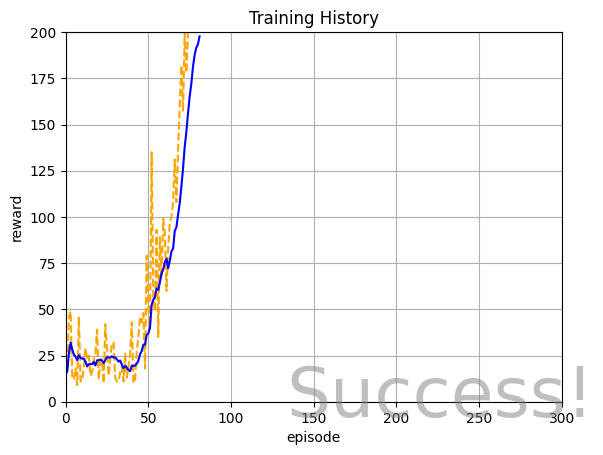

In [ ]:
gym_plotter = LivePlotter()

results = dqn_runner.run(env_name,
                         dqn.ClassicDQNLearner,
                         qn_keras.QNetwork,
                         layers=[64, 64],
                         n_episodes=200,
                         epsilon=dqn_runner.basic_epsilon_linear(1, 0.05, 1000),
                         gamma=0.99,
                         n_mini_batch=64,
                         replay_db_warmup=1000,
                         replay_db_capacity=40000,
                         c_cycle=1,
                         polyak_rate=0.99,
                         averaging_window=10,
                         victory_threshold=196,
                         diagnostics_fn=gym_plotter.live_plot,
                         output_path=output_path_gym,
                         output_name=output_name_gym)


### PyAnsys in OpenAI environment

Now we do reinforcement learning with MAPDL in the loop as an OpenAI Gym package, thanks to the PyAnsys API.

![Fig 6: A single iteration of the CartPole as a Markov Decision Process using MAPDL in pyansys](media/ANSYS_loop.jpg "Fig 6: A single iteration of the CartPole as a Markov Decision Process using MAPDL in pyansys")

**Fig 6: A single iteration of the CartPole as a Markov Decision Process using MAPDL in pyansys**

In this environment, MAPDL will provide the environment response after solving.

In [ ]:
# Calling PyAnsys Cartpole environment and generating folders for backup.
import pyansys_cartpole

env_name = 'pyansys-CartPole-v0'
tmp_path = tempfile.gettempdir()

output_path_pyansys = os.path.join(tmp_path, 'pyansys_cartpole_results', str(uuid4())) 
output_name_pyansys = 'pyansys_cartpole_00'

if not os.path.exists(output_path_pyansys):
    os.makedirs(output_path_pyansys)
print(f'Writing model in: {output_path_pyansys}')

Writing model in: C:\Users\clatapie\AppData\Local\Temp\pyansys_cartpole_results\b1cd1a4f-a645-441d-a8e3-efb9c08c70fa


We train the learner:

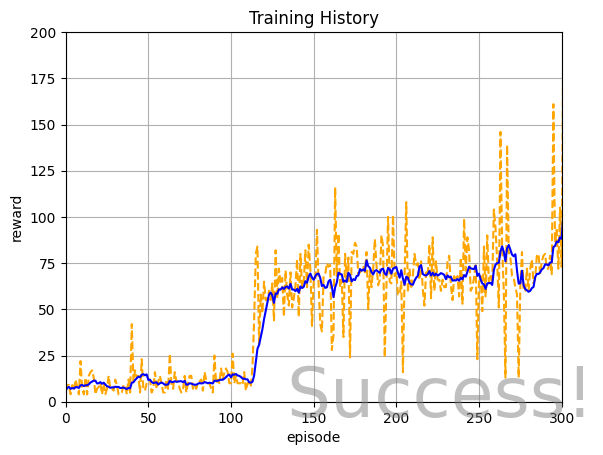

In [ ]:
pyansys_plotter = LivePlotter()

results2 = dqn_runner.run(env_name,
                         dqn.ClassicDQNLearner,
                         qn_keras.QNetwork,
                         layers=[32, 32],
                         n_episodes=5000,
                         epsilon=dqn_runner.basic_epsilon_linear(1, 0.05, 1000),
                         gamma=0.99,
                         n_mini_batch=64,
                         replay_db_warmup=1000,
                         replay_db_capacity=40000,
                         c_cycle=1,
                         polyak_rate=0.99,
                         averaging_window=10,
                         victory_threshold=196,
                         diagnostics_fn=pyansys_plotter.live_plot,
                         output_path=output_path_pyansys,
                         output_name=output_name_pyansys)

The learner is trained successfully.

### Random Agent
For comparison, here we create a simple test agent that behaves randomly and thus is not likely to succeed at the balancing task.

In [ ]:
# Importing required packages
from pyansys_dqn.test_agents import RandomAgent, TrainedAgent

env_name = 'pyansys-CartPole-v0'
env = gym.make(env_name)

agent = RandomAgent(env.action_space.n)

s = env.reset()

labels = ["Cart position", "Cart velocity", "Theta angle", "Pole velocity"]

print(" - ".join([each.center(20) for each in labels]))
print(" - ".join([ f"{each:6.3}".center(20) for each in s]))


   Cart position     -    Cart velocity     -     Theta angle      -    Pole velocity    
        0.038        -       -0.0366        -         0.122        -           0.0       


Below, notice how we inform the agent about each state transition with `agent.start_state(s)` or `agent.next_reading(s, r, done)` and then ask it to recommend an action with `agent.next_action()`.  We inform the environment this recommendation by feeding the method `env.step(a)`.  We do not expect these recommendations to be good because this agent selects at random from the choices 'left' and 'right', with equal probability.  A control algorithm that just flips a coin to select how to behave is usually not effective.  Thus, the pole should not stay balanced for long.

In [ ]:
agent.start_state(s)
done, r_tot = False, 0

print("Action - " + " - ".join([each.center(20) for each in labels]))

while not done:
    a = agent.next_action()
    s, r, done, _ = env.step(a)
    agent.next_reading(s, r, done, False)
    print('--->' if a else '<--- ', ' - ', " - ".join([ f"{each:6.3}".center(20) for each in s]))
    r_tot += r

print('\nTotal timesteps:', r_tot+1)
print(f'Final theta angle: {s[2]:4.2f} degrees')

Action -    Cart position     -    Cart velocity     -     Theta angle      -    Pole velocity    
--->  -         0.0391        -         0.107        -        -0.494        -        0.0364       
--->  -         0.0432        -         0.302        -         -2.84        -         0.107       
<---   -         0.0491        -         0.283        -         -6.17        -         0.104       
<---   -         0.0528        -        0.0883        -         -8.26        -        0.0377       
--->  -         0.0547        -         0.108        -         -9.36        -        0.0509       
--->  -         0.0588        -         0.304        -         -11.6        -         0.128       
--->  -         0.0669        -         0.499        -         -16.0        -         0.206       

Total timesteps: 8
Final theta angle: -15.97 degrees


As we see the theta in the last reported state (last row, third column), theta exceed the 12 degrees maximum, hence the simulation is stopped.

## Reusing trained agent

Now we create an agent that has been trained, i.e., that refers to a successful neural networks in order to decide how best to act. It is thus much more likely to perform well and balance the pole for a noticeably greater number of steps... all this despite having a random starting point for the system!

In [ ]:
n_actions = 2
agent = TrainedAgent(output_path_pyansys, output_name_pyansys, env.action_space.n, env.observation_space.shape)

s = env.reset()
print(" - ".join([each.center(20) for each in labels]))
print(" - ".join([ f"{each:6.3}".center(20) for each in s]))

   Cart position     -    Cart velocity     -     Theta angle      -    Pole velocity    
       -0.036        -        -0.026        -        -0.595        -           0.0       


Below, notice how we inform the agent about each state transition with `agent.start_state(s)` or `agent.next_reading(s, r, done)` and then ask it to recommend an action with `agent.next_action()`.  We follow its recommendation by feeding it into the environment in `env.step(a)`.  The recommendations should be pretty good because they stem from neural networks that store the information resulting from successful training and the pole should stay up longer, hopefully for the entirety of the episode (200 steps). 

In [ ]:
agent.start_state(s)
done, r_tot = False, 0

# print("Action - " + " - ".join([each.center(20) for each in labels])) # Uncomment to print each step

while not done:
    a = agent.next_action()
    s, r, done, _ = env.step(a)
    agent.next_reading(s, r, done, False)
    # print('---> ' if a else '<--- ', ' - ', " - ".join([ f"{each:6.3}".center(20) for each in s])) # Uncomment to print each step
    r_tot += r

print(" - ".join([each.center(20) for each in labels]))
print(" - ".join([ f"{each:6.3}".center(20) for each in s]))
print('\nTotal timesteps:', r_tot+1)
print(f'Final theta angle: {s[2]:4.2f} degrees')

1/1 [==============================] - 0s 11ms/step
   Cart position     -    Cart velocity     -     Theta angle      -    Pole velocity    
      -0.0458        -         0.227        -          4.99        -          1.76       

Total timesteps: 201
Final theta angle: 4.99 degrees


We are just printing the last time step

## Epilogue
Try resuming a trained neural network of your own!

## References

- The DQN Agent - TensofFlow.org - https://www.tensorflow.org/agents/tutorials/0_intro_rl#the_dqn_agent
- Human-level control through deep reinforcement learning - V Mnih et al.  - https://www.nature.com/articles/nature14236
